# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import os
import glob
from tqdm import tqdm
import requests
import zipfile
import json

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

seed = 12345
data = pd.read_csv('/datasets/faces/labels.csv')

In [2]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
data.shape

(7591, 2)

### График распределения возраста

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


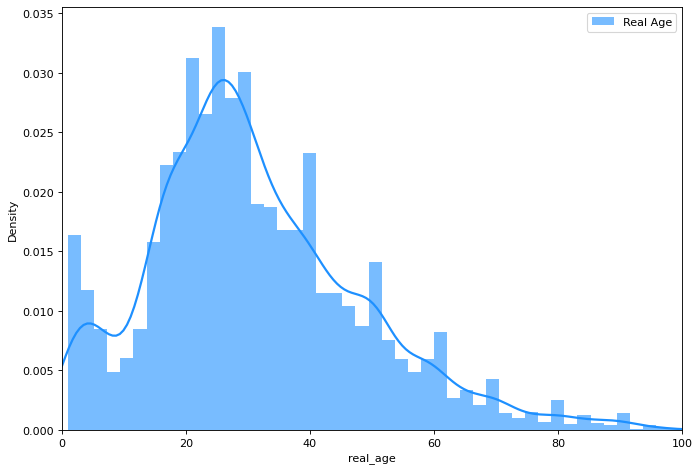

In [5]:
x1 = data['real_age']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Real Age", **kwargs)

plt.xlim(0,100)
plt.legend();

На графике видно, что есть несколько пиков, это от рождения до 3-5 лет, и от 20 до 35 лет.

### Вывод фотографий, знакомство с датасетом

In [6]:
#Масштабируем
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=90)

In [7]:
#Генерируем изображения 
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


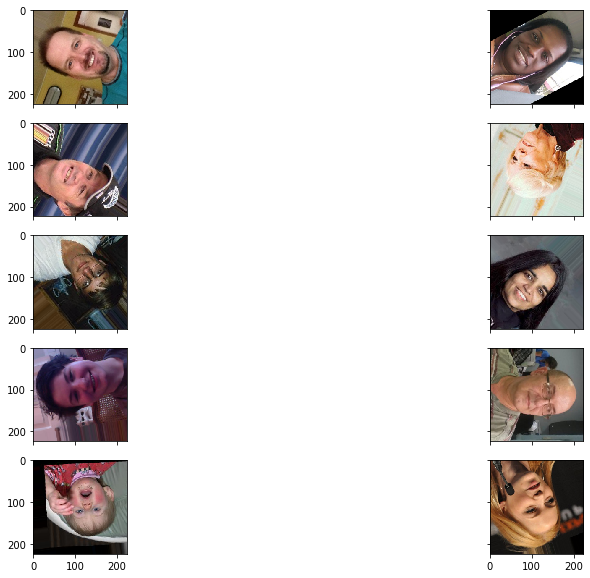

In [8]:
x,y  = train_gen_flow.next()

fig, axes = plt.subplots(ncols=2,nrows=5, sharex=True, sharey=True, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(x[i], interpolation='none')

plt.show()

In [9]:
x.shape

(32, 224, 224, 3)

### Вывод 

Длина выборки 7591 , размер изображений (224 х 224), три канала.

Наблюдаем разного размера изображения лиц, наклон различный, лицо занимает везде разную площадь фотографии.
Поворот головы также на всех фотографиях разный.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

   <def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model>

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 65s - loss: 240.7632 - mae: 11.1579 - val_loss: 553.2522 - val_mae: 18.3786

Epoch 2/10

356/356 - 41s - loss: 87.8952 - mae: 7.0651 - val_loss: 149.7035 - val_mae: 9.3247

Epoch 3/10

356/356 - 41s - loss: 59.3745 - mae: 5.8575 - val_loss: 79.2984 - val_mae: 6.5397

Epoch 4/10

356/356 - 41s - loss: 41.4595 - mae: 4.8972 - val_loss: 83.0105 - val_mae: 7.0531

Epoch 5/10

356/356 - 41s - loss: 31.1028 - mae: 4.2606 - val_loss: 106.4470 - val_mae: 7.8688

Epoch 6/10

356/356 - 41s - loss: 25.4344 - mae: 3.8781 - val_loss: 87.8703 - val_mae: 7.0805

Epoch 7/10

356/356 - 42s - loss: 22.9904 - mae: 3.6563 - val_loss: 69.2707 - val_mae: 6.2094

Epoch 8/10

356/356 - 41s - loss: 19.3479 - mae: 3.3321 - val_loss: 67.9088 - val_mae: 6.2380

Epoch 9/10

356/356 - 41s - loss: 14.5982 - mae: 2.9198 - val_loss: 69.5261 - val_mae: 6.2006

Epoch 10/10

356/356 - 42s - loss: 12.4670 - mae: 2.6963 - val_loss: 63.2035 - val_mae: 5.8703

119/119 - 10s - loss: 63.2035 - mae: 5.8703

Test MAE: 5.8703

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Для выполнения поставленной задачи наилучше всего справилась модель ResNet50.

Требование предъявленное к проекту - ВЫПОЛНЕНО!

Этот диапазон подходит для определения возрастной группы покупателей, для анализа покупок, чтобы в дальнейшем можно было предлагать товары, в которых заинтересованы покупатели этой возрастной группы.


Диапазон определения является обширным для того, чтобы определять возраст совершенолетия покупателя при приобритении алкоголя, но подходит для того чтобы определять возрастные группы, анализировать покупки и предлагать товары, которые могут заинтересовать потенциальных покупателей.